# MLP
Like MLP_269 but run on every cell line individually.

In [25]:

from datetime import datetime
print(datetime.now())

2023-04-19 12:14:45.477333


In [26]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [27]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
# EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_269'

Python 3.9.16
sklearn 1.2.2


In [28]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = 'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = 'test.canon_lncRNA_transcripts.csv'

In [29]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [30]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    string = fields[cell_line]
                    if string != 'nan':
                        value = float(string)
                        self.gene2rci[gene_id] = value
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [31]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [32]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-19 12:14:47.270163
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               131328    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 143,809
Train

## Training

In [33]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd)  # no validation )
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [34]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

In [35]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)




2023-04-19 12:14:47.544341
Cell Line 0 A549
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1630
Num RCI: 1630
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 1630 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 387
Num RCI: 387
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 387 sequences.

Training # 1 1
2023-04-19 12:14:51.176750
2023-04-19 12:14:51.176846
Discriminator is GMM
Means [0.3824423335786255, -2.113043835924107]
Variances [1.19222998 1.37313111]
Priors [0.63484854 0.36515146]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 1082:548 66.38%
Computed cla

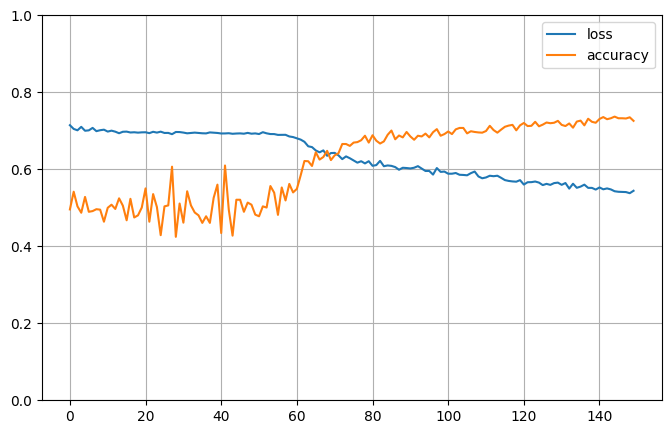


Testing # 1 1
2023-04-19 12:16:15.794408
2023-04-19 12:16:15.794819
PREDICT
2023-04-19 12:16:15.808191
Test 1:0 246:141 63.57%
Predict 1:0 209:178 54.01%
Test sizes (387, 1025) (387,)
Distrib of scores: 0.5064976 mean 0.2424416 std
Range of scores: 0.015223182 to 0.9743552
Score threshold 0.5
Confusion matrix
 [[ 92  49]
 [ 86 160]]
Normalized matrix
 [[0.2377261  0.12661499]
 [0.22222222 0.41343669]]
Extreme scores correct, pos:neg 104 69
Extreme scores incorrect pos:neg 32 51


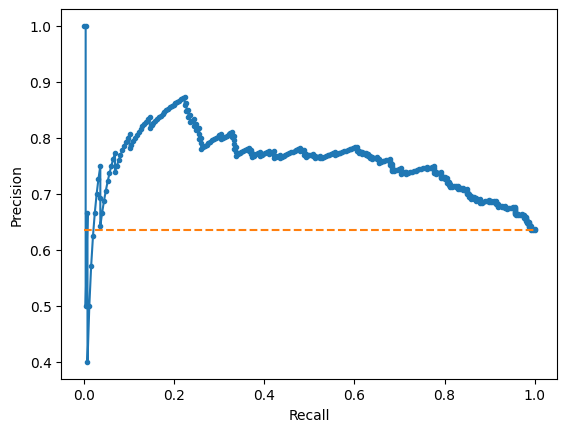

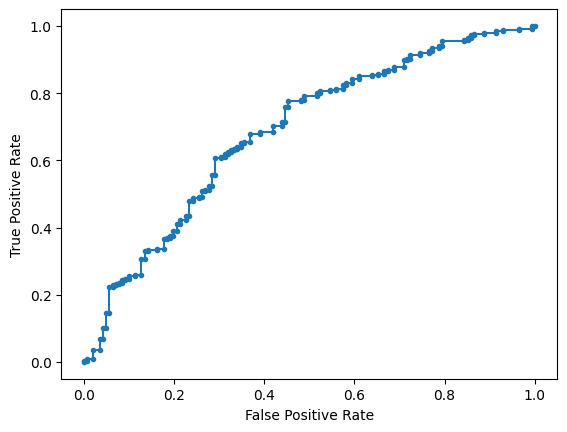

Accuracy: 65.12% Precision: 76.56% Recall: 65.04%
F1: 70.33% MCC: 0.2925
AUPRC: 75.66% AUROC: 68.63%
 accuracy [65.11627906976744]
 precision [76.55502392344498]
 recall [65.04065040650406]
 F1 [70.32967032967034]
 MCC [0.29246718320663667]
 AUPRC [75.66140164685902]
 AUROC [68.62711180303293]
 accuracy mean 65.12% std nan
 precision mean 76.56% std nan
 recall mean 65.04% std nan
 F1 mean 70.33% std nan
 MCC mean 0.2925 std nan
 AUPRC mean 75.66% std nan
 AUROC mean 68.63% std nan
 accuracy [[65.11627906976744]]
 precision [[76.55502392344498]]
 recall [[65.04065040650406]]
 F1 [[70.32967032967034]]
 MCC [[0.29246718320663667]]
 AUPRC [[75.66140164685902]]
 AUROC [[68.62711180303293]]

2023-04-19 12:16:16.754206
Cell Line 1 H1.hESC
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 2982
Num RCI: 2982
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 2982 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 728
Num RCI: 728
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 728 sequences.

Training # 1 1
2023-04-19 12:16:23.442322
2023-04-19 12:16:23.442404
Discriminator is GMM
Means [-1.4482882755188413, 0.40146284378281777]
Variances [1.57888046 1.55005853]
Priors [0.43862137 0.56137863]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1768:1214 59.29%
Computed class weights: {0: 1.228171334431631, 1: 0.8433257918552036}
FIT
2023-04-19 12:16:24.752419


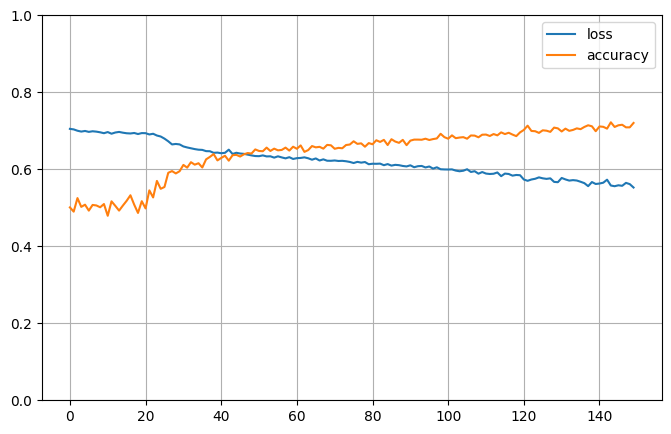


Testing # 1 1
2023-04-19 12:18:48.014384
2023-04-19 12:18:48.014436
PREDICT
2023-04-19 12:18:48.024016
Test 1:0 426:302 58.52%
Predict 1:0 377:351 51.79%
Test sizes (728, 1025) (728,)
Distrib of scores: 0.4973017 mean 0.230691 std
Range of scores: 0.0072114877 to 0.9818649
Score threshold 0.5
Confusion matrix
 [[193 109]
 [158 268]]
Normalized matrix
 [[0.26510989 0.14972527]
 [0.21703297 0.36813187]]
Extreme scores correct, pos:neg 163 127
Extreme scores incorrect pos:neg 55 87


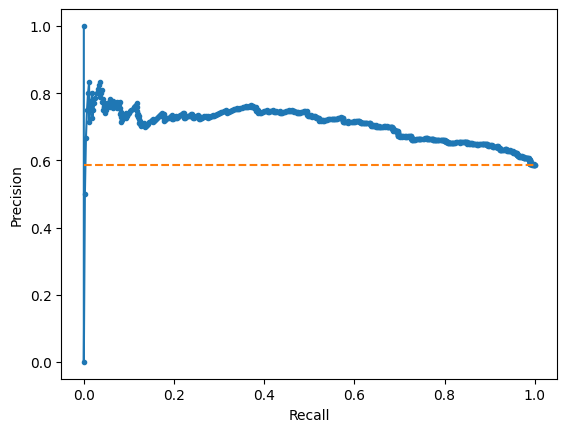

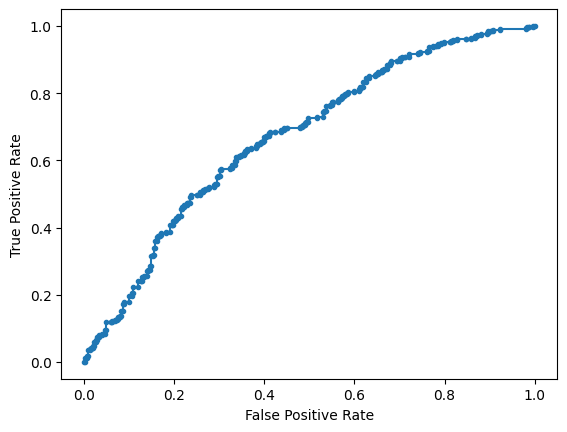

Accuracy: 63.32% Precision: 71.09% Recall: 62.91%
F1: 66.75% MCC: 0.2644
AUPRC: 70.63% AUROC: 67.01%
 accuracy [63.324175824175825]
 precision [71.08753315649867]
 recall [62.91079812206573]
 F1 [66.74968866749688]
 MCC [0.2644306341218906]
 AUPRC [70.62968572235785]
 AUROC [67.00867456393993]
 accuracy mean 63.32% std nan
 precision mean 71.09% std nan
 recall mean 62.91% std nan
 F1 mean 66.75% std nan
 MCC mean 0.2644 std nan
 AUPRC mean 70.63% std nan
 AUROC mean 67.01% std nan
 accuracy [[63.324175824175825]]
 precision [[71.08753315649867]]
 recall [[62.91079812206573]]
 F1 [[66.74968866749688]]
 MCC [[0.2644306341218906]]
 AUPRC [[70.62968572235785]]
 AUROC [[67.00867456393993]]

2023-04-19 12:18:48.653430
Cell Line 2 HeLa.S3
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1008
Num RCI: 1008
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1008 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 239
Num RCI: 239
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 239 sequences.

Training # 1 1
2023-04-19 12:18:50.904113
2023-04-19 12:18:50.904201
Discriminator is GMM
Means [-2.818421831978961, -0.4164065766455784]
Variances [2.04342939 1.90070251]
Priors [0.46739385 0.53260615]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 556:452 55.16%
Computed class weights: {0: 1.1150442477876106, 1: 0.9064748201438849}
FIT
2023-04-19 12:18:51.763169


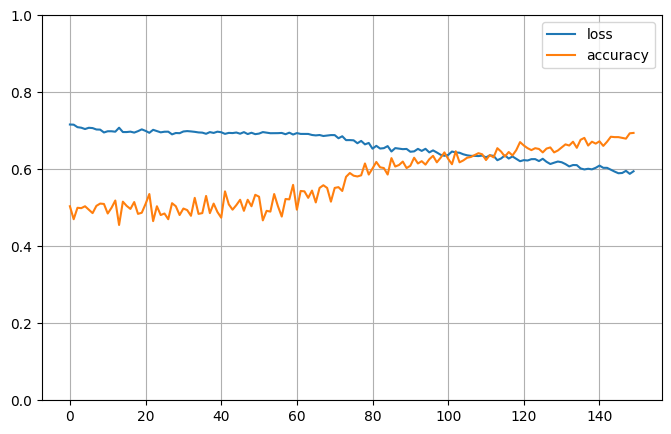


Testing # 1 1
2023-04-19 12:19:34.090075
2023-04-19 12:19:34.090128
PREDICT
2023-04-19 12:19:34.096937
Test 1:0 115:124 48.12%
Predict 1:0 96:143 40.17%
Test sizes (239, 1025) (239,)
Distrib of scores: 0.42304245 mean 0.2016672 std
Range of scores: 0.047944237 to 0.8428242
Score threshold 0.5
Confusion matrix
 [[84 40]
 [59 56]]
Normalized matrix
 [[0.35146444 0.16736402]
 [0.24686192 0.23430962]]
Extreme scores correct, pos:neg 17 63
Extreme scores incorrect pos:neg 18 29


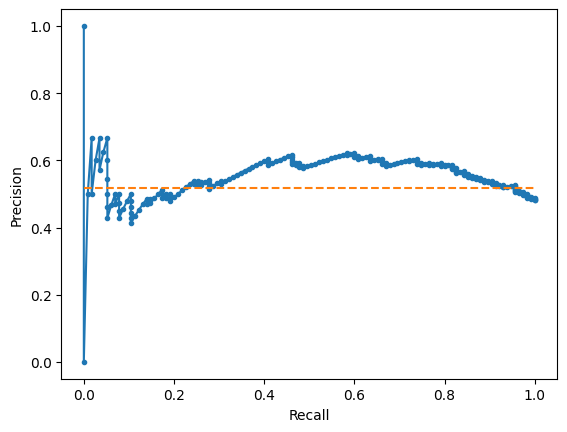

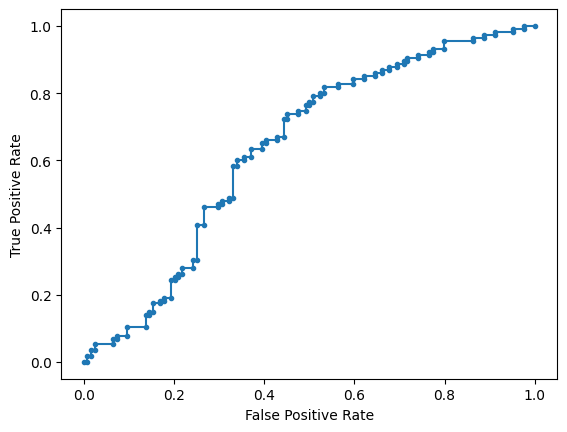

Accuracy: 58.58% Precision: 58.33% Recall: 48.70%
F1: 53.08% MCC: 0.1675
AUPRC: 55.36% AUROC: 63.80%
 accuracy [58.57740585774059]
 precision [58.333333333333336]
 recall [48.69565217391305]
 F1 [53.08056872037915]
 MCC [0.16753062524416584]
 AUPRC [55.357787535051806]
 AUROC [63.800841514726514]
 accuracy mean 58.58% std nan
 precision mean 58.33% std nan
 recall mean 48.70% std nan
 F1 mean 53.08% std nan
 MCC mean 0.1675 std nan
 AUPRC mean 55.36% std nan
 AUROC mean 63.80% std nan
 accuracy [[58.57740585774059]]
 precision [[58.333333333333336]]
 recall [[48.69565217391305]]
 F1 [[53.08056872037915]]
 MCC [[0.16753062524416584]]
 AUPRC [[55.357787535051806]]
 AUROC [[63.800841514726514]]

2023-04-19 12:19:34.668451
Cell Line 3 HepG2
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1516
Num RCI: 1516
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/t

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1516 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 383
Num RCI: 383
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 383 sequences.

Training # 1 1
2023-04-19 12:19:40.646901
2023-04-19 12:19:40.646998
Discriminator is GMM
Means [-0.20664239362691122, -3.0277815228385685]
Variances [1.66709545 2.56504726]
Priors [0.57204875 0.42795125]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 915:601 60.36%
Computed class weights: {0: 1.2612312811980033, 1: 0.8284153005464481}
FIT
2023-04-19 12:19:41.476854


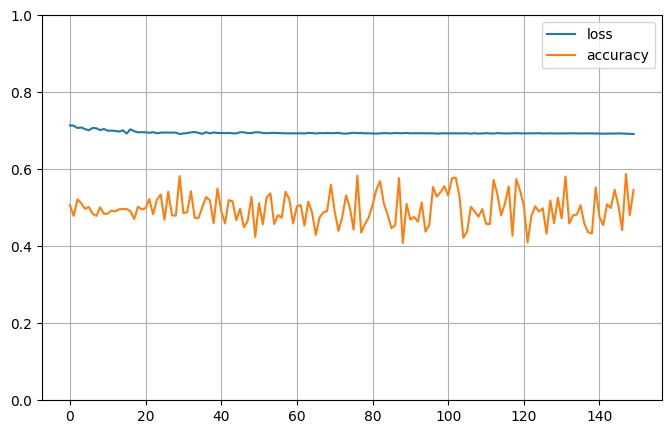


Testing # 1 1
2023-04-19 12:20:23.868494
2023-04-19 12:20:23.868567
PREDICT
2023-04-19 12:20:23.872959
Test 1:0 226:157 59.01%
Predict 1:0 0:383  0.00%
Test sizes (383, 1025) (383,)
Distrib of scores: 0.4844777 mean 0.003008598 std
Range of scores: 0.4791928 to 0.4981965
Score threshold 0.5
Confusion matrix
 [[157   0]
 [226   0]]
Normalized matrix
 [[0.40992167 0.        ]
 [0.59007833 0.        ]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


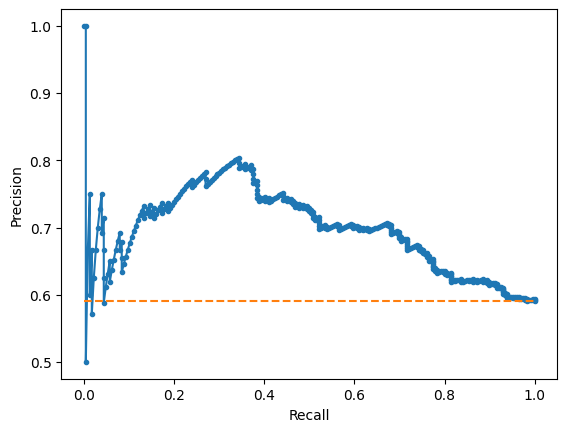

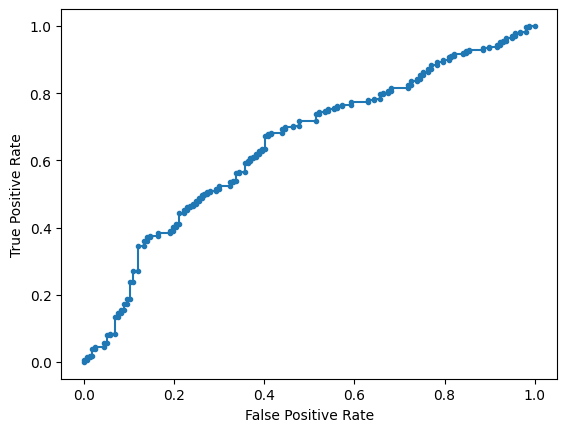

Accuracy: 40.99% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 69.65% AUROC: 64.51%
 accuracy [40.992167101827675]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [69.64765106862336]
 AUROC [64.5087650076095]
 accuracy mean 40.99% std nan
 precision mean 0.00% std nan
 recall mean 0.00% std nan
 F1 mean 0.00% std nan
 MCC mean 0.0000 std nan
 AUPRC mean 69.65% std nan
 AUROC mean 64.51% std nan
 accuracy [[40.992167101827675]]
 precision [[0.0]]
 recall [[0.0]]
 F1 [[0.0]]
 MCC [[0.0]]
 AUPRC [[69.64765106862336]]
 AUROC [[64.5087650076095]]

2023-04-19 12:20:24.570019
Cell Line 4 HT1080
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1025
Num RCI: 1025
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1025 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 262
Num RCI: 262
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 262 sequences.

Training # 1 1
2023-04-19 12:20:27.324121
2023-04-19 12:20:27.324195
Discriminator is GMM
Means [0.41825457993226073, -2.151948974499462]
Variances [1.31883278 2.80568508]
Priors [0.61412702 0.38587298]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 686:339 66.93%
Computed class weights: {0: 1.5117994100294985, 1: 0.7470845481049563}
FIT
2023-04-19 12:20:28.091422


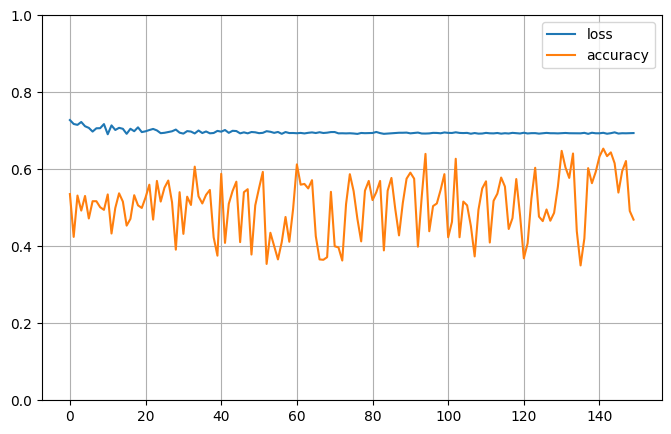


Testing # 1 1
2023-04-19 12:20:56.055136
2023-04-19 12:20:56.055189
PREDICT
2023-04-19 12:20:56.063096
Test 1:0 177:85 67.56%
Predict 1:0 259:3 98.85%
Test sizes (262, 1025) (262,)
Distrib of scores: 0.5002513 mean 0.00014135022 std
Range of scores: 0.49987426 to 0.50090134
Score threshold 0.5
Confusion matrix
 [[  0  85]
 [  3 174]]
Normalized matrix
 [[0.         0.32442748]
 [0.01145038 0.66412214]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


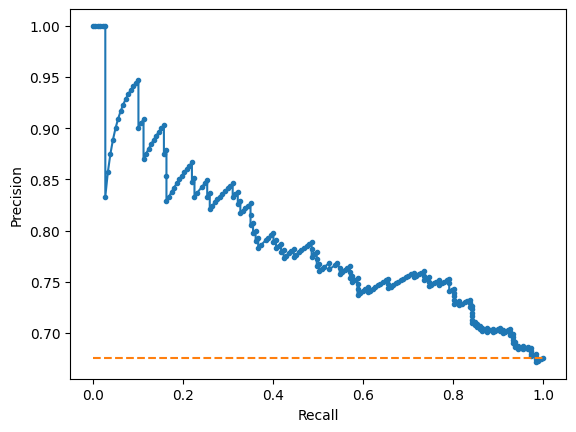

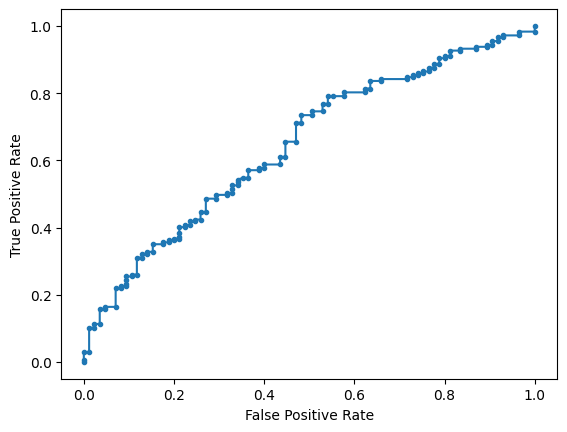

Accuracy: 66.41% Precision: 67.18% Recall: 98.31%
F1: 79.82% MCC: -0.0746
AUPRC: 79.06% AUROC: 64.70%
 accuracy [66.41221374045801]
 precision [67.18146718146718]
 recall [98.30508474576271]
 F1 [79.8165137614679]
 MCC [-0.07458192267286916]
 AUPRC [79.05896385019966]
 AUROC [64.69591226321036]
 accuracy mean 66.41% std nan
 precision mean 67.18% std nan
 recall mean 98.31% std nan
 F1 mean 79.82% std nan
 MCC mean -0.0746 std nan
 AUPRC mean 79.06% std nan
 AUROC mean 64.70% std nan
 accuracy [[66.41221374045801]]
 precision [[67.18146718146718]]
 recall [[98.30508474576271]]
 F1 [[79.8165137614679]]
 MCC [[-0.07458192267286916]]
 AUPRC [[79.05896385019966]]
 AUROC [[64.69591226321036]]

2023-04-19 12:20:56.726622
Cell Line 5 HUVEC
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1680
Num RCI: 1680
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1680 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 408
Num RCI: 408
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 408 sequences.

Training # 1 1
2023-04-19 12:21:00.530684
2023-04-19 12:21:00.530766
Discriminator is GMM
Means [-0.13561061104225194, -3.1148435538351538]
Variances [1.89858956 2.52809231]
Priors [0.57830047 0.42169953]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 1027:653 61.13%
Computed class weights: {0: 1.2863705972434916, 1: 0.8179162609542356}
FIT
2023-04-19 12:21:04.262726


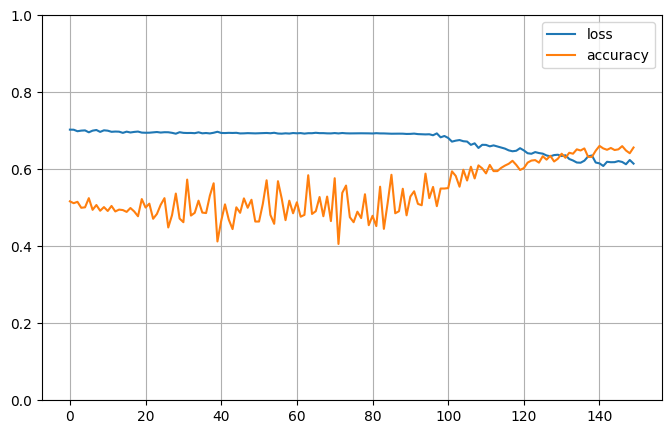


Testing # 1 1
2023-04-19 12:21:47.622582
2023-04-19 12:21:47.623009
PREDICT
2023-04-19 12:21:47.627644
Test 1:0 243:165 59.56%
Predict 1:0 214:194 52.45%
Test sizes (408, 1025) (408,)
Distrib of scores: 0.519344 mean 0.16687463 std
Range of scores: 0.08739045 to 0.88462543
Score threshold 0.5
Confusion matrix
 [[104  61]
 [ 90 153]]
Normalized matrix
 [[0.25490196 0.1495098 ]
 [0.22058824 0.375     ]]
Extreme scores correct, pos:neg 70 41
Extreme scores incorrect pos:neg 22 28


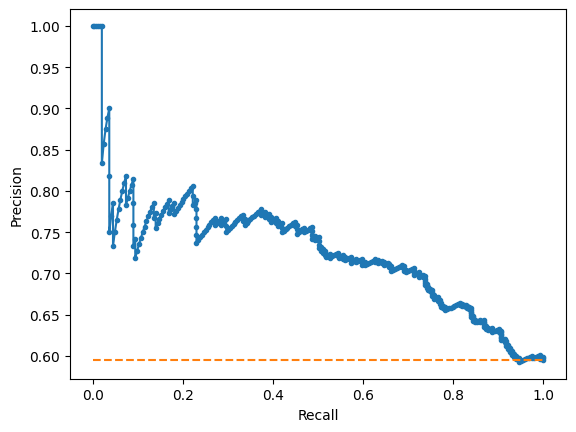

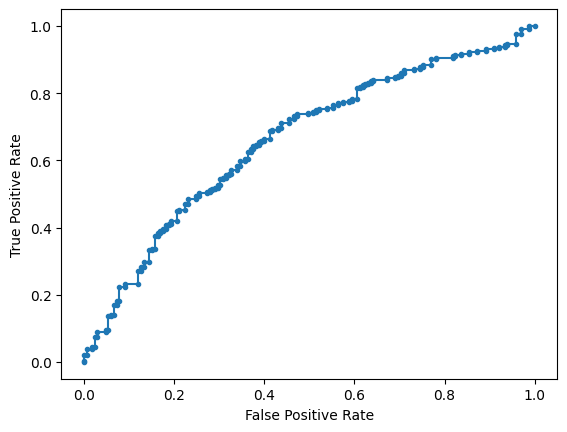

Accuracy: 62.99% Precision: 71.50% Recall: 62.96%
F1: 66.96% MCC: 0.2554
AUPRC: 72.58% AUROC: 65.96%
 accuracy [62.99019607843137]
 precision [71.49532710280374]
 recall [62.96296296296296]
 F1 [66.95842450765865]
 MCC [0.25544547168088255]
 AUPRC [72.5836124534892]
 AUROC [65.95834892131188]
 accuracy mean 62.99% std nan
 precision mean 71.50% std nan
 recall mean 62.96% std nan
 F1 mean 66.96% std nan
 MCC mean 0.2554 std nan
 AUPRC mean 72.58% std nan
 AUROC mean 65.96% std nan
 accuracy [[62.99019607843137]]
 precision [[71.49532710280374]]
 recall [[62.96296296296296]]
 F1 [[66.95842450765865]]
 MCC [[0.25544547168088255]]
 AUPRC [[72.5836124534892]]
 AUROC [[65.95834892131188]]

2023-04-19 12:21:48.296170
Cell Line 6 MCF.7
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 2361
Num RCI: 2361
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.can

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 2361 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 588
Num RCI: 588
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 588 sequences.

Training # 1 1
2023-04-19 12:21:52.993203
2023-04-19 12:21:52.993403
Discriminator is GMM
Means [-3.2669503183780497, -0.1445817540767038]
Variances [2.62061738 2.19280847]
Priors [0.46079175 0.53920825]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 1308:1053 55.40%
Computed class weights: {0: 1.121082621082621, 1: 0.9025229357798165}
FIT
2023-04-19 12:21:54.006845


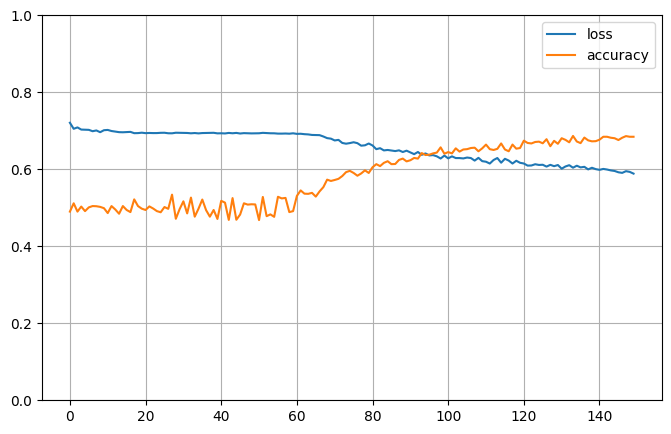


Testing # 1 1
2023-04-19 12:22:53.440440
2023-04-19 12:22:53.441062
PREDICT
2023-04-19 12:22:53.445669
Test 1:0 344:244 58.50%
Predict 1:0 325:263 55.27%
Test sizes (588, 1025) (588,)
Distrib of scores: 0.51215464 mean 0.19120021 std
Range of scores: 0.025699621 to 0.87595195
Score threshold 0.5
Confusion matrix
 [[145  99]
 [118 226]]
Normalized matrix
 [[0.24659864 0.16836735]
 [0.20068027 0.38435374]]
Extreme scores correct, pos:neg 117 83
Extreme scores incorrect pos:neg 42 54


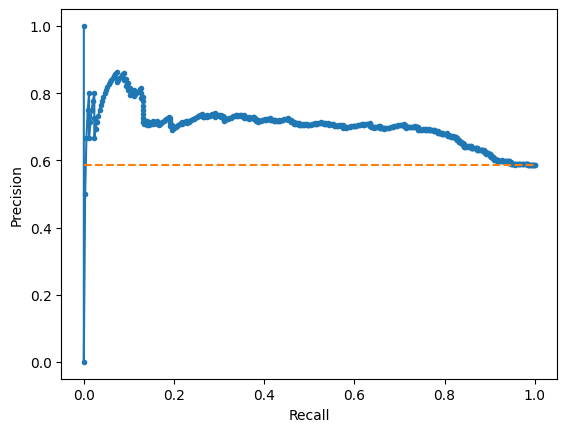

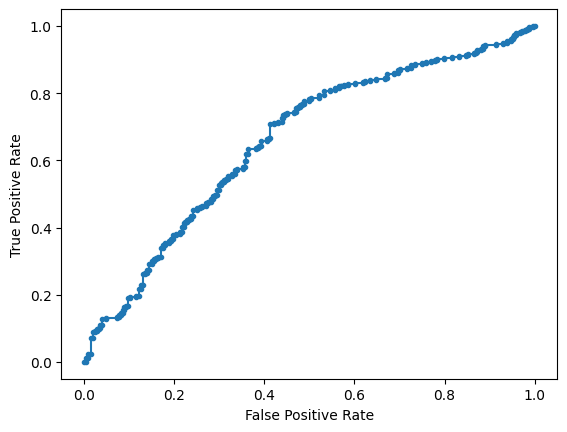

Accuracy: 63.10% Precision: 69.54% Recall: 65.70%
F1: 67.56% MCC: 0.2490
AUPRC: 70.22% AUROC: 65.78%
 accuracy [63.095238095238095]
 precision [69.53846153846153]
 recall [65.69767441860465]
 F1 [67.56352765321375]
 MCC [0.24896695273013061]
 AUPRC [70.21636219896139]
 AUROC [65.7751143728555]
 accuracy mean 63.10% std nan
 precision mean 69.54% std nan
 recall mean 65.70% std nan
 F1 mean 67.56% std nan
 MCC mean 0.2490 std nan
 AUPRC mean 70.22% std nan
 AUROC mean 65.78% std nan
 accuracy [[63.095238095238095]]
 precision [[69.53846153846153]]
 recall [[65.69767441860465]]
 F1 [[67.56352765321375]]
 MCC [[0.24896695273013061]]
 AUPRC [[70.21636219896139]]
 AUROC [[65.7751143728555]]

2023-04-19 12:22:54.388727
Cell Line 7 NCI.H460
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 695
Num RCI: 695
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 695 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 165
Num RCI: 165
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 165 sequences.

Training # 1 1
2023-04-19 12:22:58.209539
2023-04-19 12:22:58.209608
Discriminator is GMM
Means [-0.7499228329865164, -3.0108672255506024]
Variances [2.1853445  3.12369922]
Priors [0.67868669 0.32131331]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
Train 1:0 539:156 77.55%
Computed class weights: {0: 2.2275641025641026, 1: 0.6447124304267161}
FIT
2023-04-19 12:22:58.946950


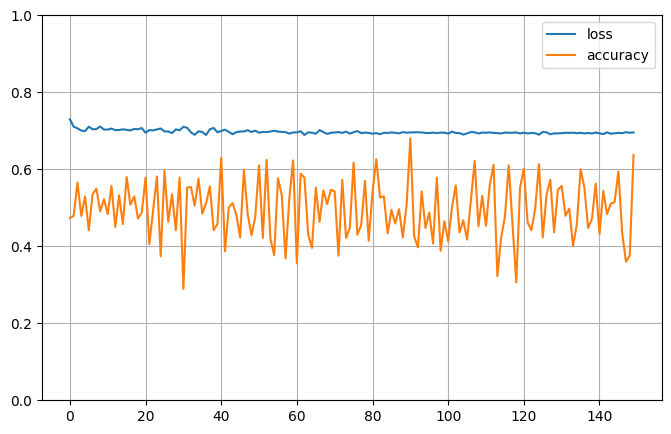


Testing # 1 1
2023-04-19 12:23:18.484151
2023-04-19 12:23:18.484199
PREDICT
2023-04-19 12:23:18.489498
Test 1:0 120:45 72.73%
Predict 1:0 165:0 100.00%
Test sizes (165, 1025) (165,)
Distrib of scores: 0.5116879 mean 0.00034176704 std
Range of scores: 0.5107529 to 0.5124298
Score threshold 0.5
Confusion matrix
 [[  0  45]
 [  0 120]]
Normalized matrix
 [[0.         0.27272727]
 [0.         0.72727273]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


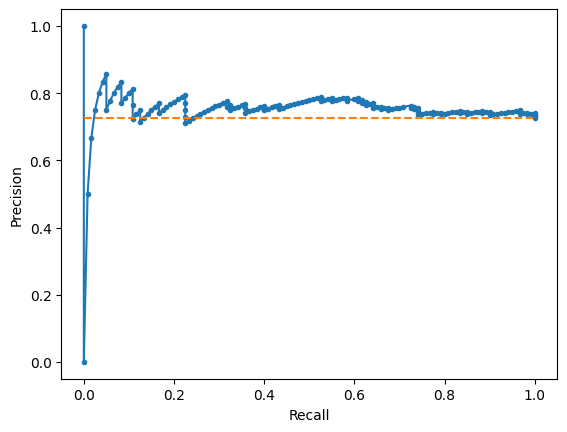

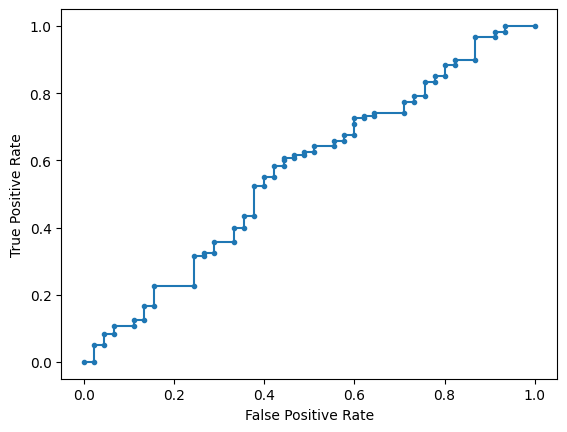

Accuracy: 72.73% Precision: 72.73% Recall: 100.00%
F1: 84.21% MCC: 0.0000
AUPRC: 75.30% AUROC: 56.43%
 accuracy [72.72727272727273]
 precision [72.72727272727273]
 recall [100.0]
 F1 [84.21052631578948]
 MCC [0.0]
 AUPRC [75.29536745140285]
 AUROC [56.425925925925924]
 accuracy mean 72.73% std nan
 precision mean 72.73% std nan
 recall mean 100.00% std nan
 F1 mean 84.21% std nan
 MCC mean 0.0000 std nan
 AUPRC mean 75.30% std nan
 AUROC mean 56.43% std nan
 accuracy [[72.72727272727273]]
 precision [[72.72727272727273]]
 recall [[100.0]]
 F1 [[84.21052631578948]]
 MCC [[0.0]]
 AUPRC [[75.29536745140285]]
 AUROC [[56.425925925925924]]

2023-04-19 12:23:19.084124
Cell Line 8 NHEK
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1208
Num RCI: 1208
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1208 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 288
Num RCI: 288
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 288 sequences.

Training # 1 1
2023-04-19 12:23:22.121673
2023-04-19 12:23:22.121757
Discriminator is GMM
Means [-2.9218121124567493, -0.18715450950521162]
Variances [3.1629524  1.59780369]
Priors [0.36670603 0.63329397]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 833:375 68.96%
Computed class weights: {0: 1.6106666666666667, 1: 0.7250900360144058}
FIT
2023-04-19 12:23:25.571059


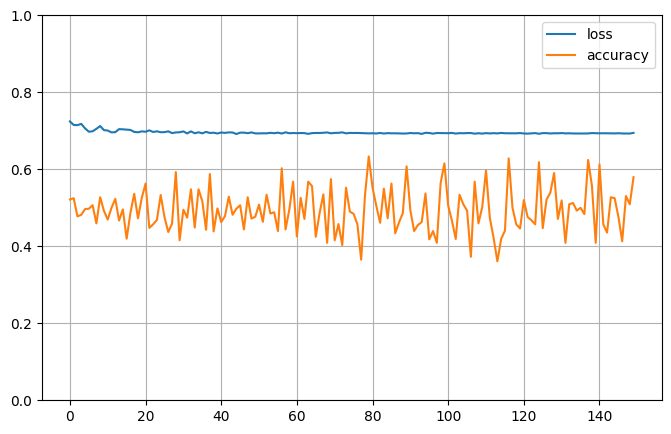


Testing # 1 1
2023-04-19 12:23:58.541290
2023-04-19 12:23:58.541344
PREDICT
2023-04-19 12:23:58.547997
Test 1:0 193:95 67.01%
Predict 1:0 0:288  0.00%
Test sizes (288, 1025) (288,)
Distrib of scores: 0.49867025 mean 0.00023701858 std
Range of scores: 0.49806696 to 0.49993858
Score threshold 0.5
Confusion matrix
 [[ 95   0]
 [193   0]]
Normalized matrix
 [[0.32986111 0.        ]
 [0.67013889 0.        ]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


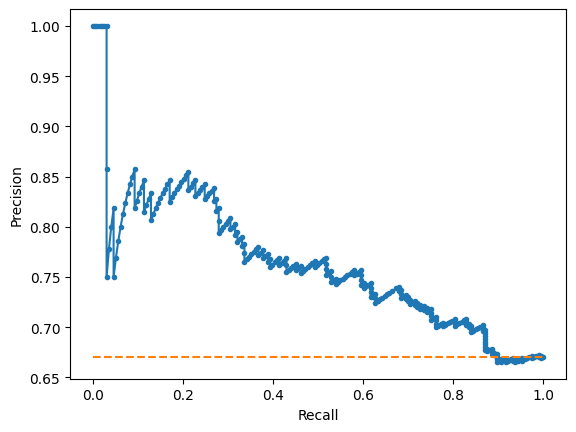

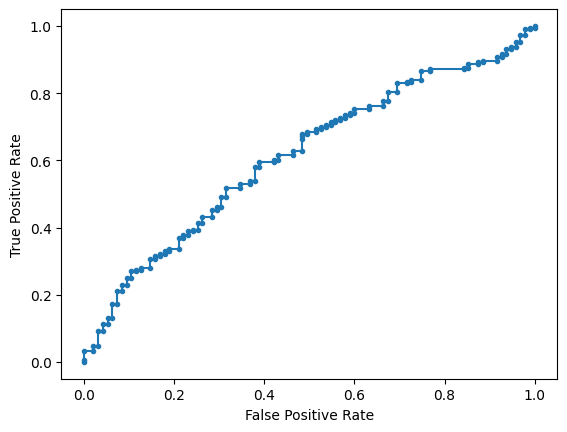

Accuracy: 32.99% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 76.31% AUROC: 61.39%
 accuracy [32.98611111111111]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [76.31149329529177]
 AUROC [61.39078265612218]
 accuracy mean 32.99% std nan
 precision mean 0.00% std nan
 recall mean 0.00% std nan
 F1 mean 0.00% std nan
 MCC mean 0.0000 std nan
 AUPRC mean 76.31% std nan
 AUROC mean 61.39% std nan
 accuracy [[32.98611111111111]]
 precision [[0.0]]
 recall [[0.0]]
 F1 [[0.0]]
 MCC [[0.0]]
 AUPRC [[76.31149329529177]]
 AUROC [[61.39078265612218]]

2023-04-19 12:23:59.201942
Cell Line 9 SK.MEL.5
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 605
Num RCI: 605
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 605 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 158
Num RCI: 158
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 158 sequences.

Training # 1 1
2023-04-19 12:24:00.993592
2023-04-19 12:24:00.993669
Discriminator is GMM
Means [-0.7005275969105765, -3.641821507007351]
Variances [2.28787762 3.84438107]
Priors [0.62812313 0.37187687]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
Train 1:0 422:183 69.75%
Computed class weights: {0: 1.6530054644808743, 1: 0.716824644549763}
FIT
2023-04-19 12:24:01.728390


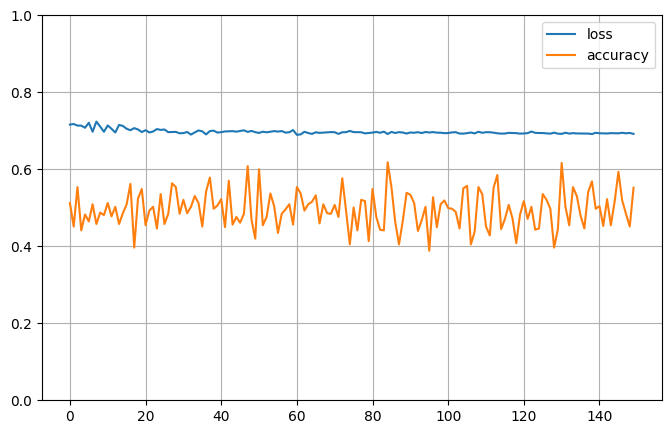


Testing # 1 1
2023-04-19 12:24:23.628968
2023-04-19 12:24:23.629017
PREDICT
2023-04-19 12:24:23.635934
Test 1:0 112:46 70.89%
Predict 1:0 6:152  3.80%
Test sizes (158, 1025) (158,)
Distrib of scores: 0.49957103 mean 0.00023608198 std
Range of scores: 0.498978 to 0.50052583
Score threshold 0.5
Confusion matrix
 [[ 45   1]
 [107   5]]
Normalized matrix
 [[0.28481013 0.00632911]
 [0.67721519 0.03164557]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


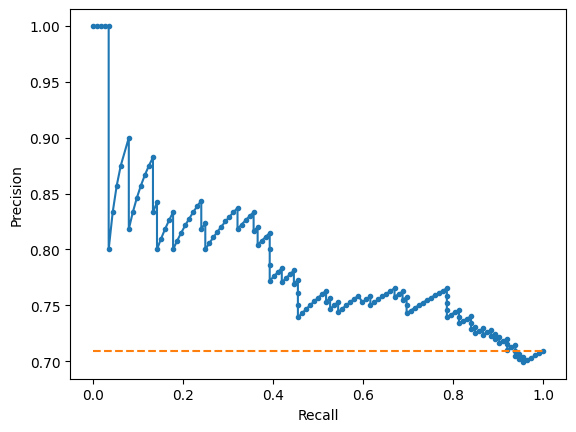

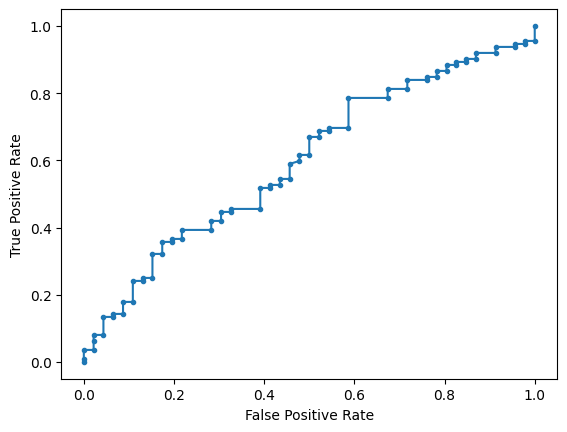

Accuracy: 31.65% Precision: 83.33% Recall: 4.46%
F1: 8.47% MCC: 0.0544
AUPRC: 78.47% AUROC: 59.83%
 accuracy [31.645569620253166]
 precision [83.33333333333334]
 recall [4.464285714285714]
 F1 [8.47457627118644]
 MCC [0.05443731055270271]
 AUPRC [78.46719572431297]
 AUROC [59.83113354037267]
 accuracy mean 31.65% std nan
 precision mean 83.33% std nan
 recall mean 4.46% std nan
 F1 mean 8.47% std nan
 MCC mean 0.0544 std nan
 AUPRC mean 78.47% std nan
 AUROC mean 59.83% std nan
 accuracy [[31.645569620253166]]
 precision [[83.33333333333334]]
 recall [[4.464285714285714]]
 F1 [[8.47457627118644]]
 MCC [[0.05443731055270271]]
 AUPRC [[78.46719572431297]]
 AUROC [[59.83113354037267]]

2023-04-19 12:24:24.262324
Cell Line 10 SK.N.DZ
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 677
Num RCI: 677
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.cano

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 677 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 170
Num RCI: 170
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 170 sequences.

Training # 1 1
2023-04-19 12:24:26.420327
2023-04-19 12:24:26.420405
Discriminator is GMM
Means [-2.102332474894561, 0.019638573421281558]
Variances [2.56586809 1.11014878]
Priors [0.29417563 0.70582437]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 540:137 79.76%
Computed class weights: {0: 2.4708029197080292, 1: 0.6268518518518519}
FIT
2023-04-19 12:24:27.123808


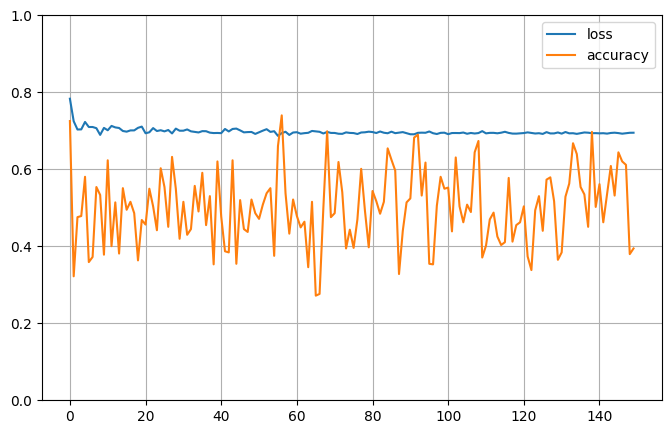


Testing # 1 1
2023-04-19 12:24:46.284978
2023-04-19 12:24:46.285389
PREDICT
2023-04-19 12:24:46.288168
Test 1:0 128:42 75.29%
Predict 1:0 0:170  0.00%
Test sizes (170, 1025) (170,)
Distrib of scores: 0.49312958 mean 0.0001765113 std
Range of scores: 0.49267483 to 0.4935661
Score threshold 0.5
Confusion matrix
 [[ 42   0]
 [128   0]]
Normalized matrix
 [[0.24705882 0.        ]
 [0.75294118 0.        ]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


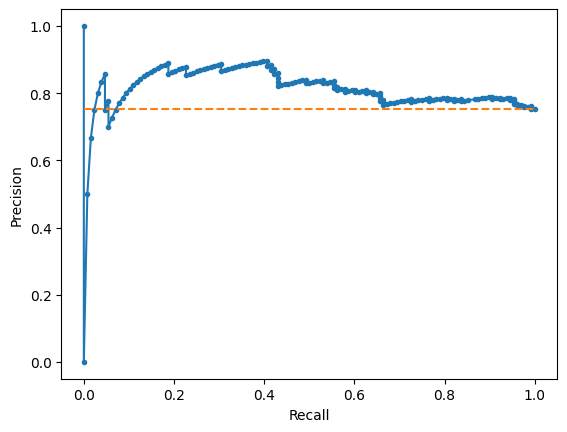

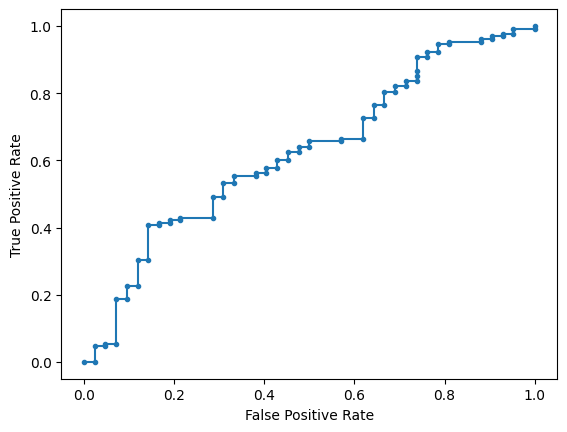

Accuracy: 24.71% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 81.17% AUROC: 62.54%
 accuracy [24.705882352941178]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [81.17384781792228]
 AUROC [62.53720238095239]
 accuracy mean 24.71% std nan
 precision mean 0.00% std nan
 recall mean 0.00% std nan
 F1 mean 0.00% std nan
 MCC mean 0.0000 std nan
 AUPRC mean 81.17% std nan
 AUROC mean 62.54% std nan
 accuracy [[24.705882352941178]]
 precision [[0.0]]
 recall [[0.0]]
 F1 [[0.0]]
 MCC [[0.0]]
 AUPRC [[81.17384781792228]]
 AUROC [[62.53720238095239]]

2023-04-19 12:24:47.173316
Cell Line 11 SK.N.SH
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1819
Num RCI: 1819
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1819 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 471
Num RCI: 471
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 471 sequences.

Training # 1 1
2023-04-19 12:24:52.219535
2023-04-19 12:24:52.219613
Discriminator is GMM
Means [-0.1125226175752773, -3.110502675077478]
Variances [2.05941152 2.93675041]
Priors [0.5736103 0.4263897]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 1099:720 60.42%
Computed class weights: {0: 1.2631944444444445, 1: 0.8275705186533212}
FIT
2023-04-19 12:24:53.222701


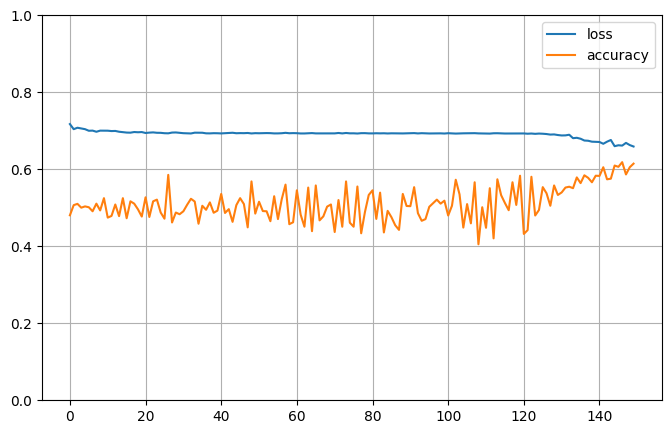


Testing # 1 1
2023-04-19 12:26:16.552446
2023-04-19 12:26:16.552500
PREDICT
2023-04-19 12:26:16.556512
Test 1:0 287:184 60.93%
Predict 1:0 273:198 57.96%
Test sizes (471, 1025) (471,)
Distrib of scores: 0.5063628 mean 0.10869963 std
Range of scores: 0.18728769 to 0.7486461
Score threshold 0.5
Confusion matrix
 [[ 99  85]
 [ 99 188]]
Normalized matrix
 [[0.21019108 0.18046709]
 [0.21019108 0.39915074]]
Extreme scores correct, pos:neg 22 30
Extreme scores incorrect pos:neg 11 15


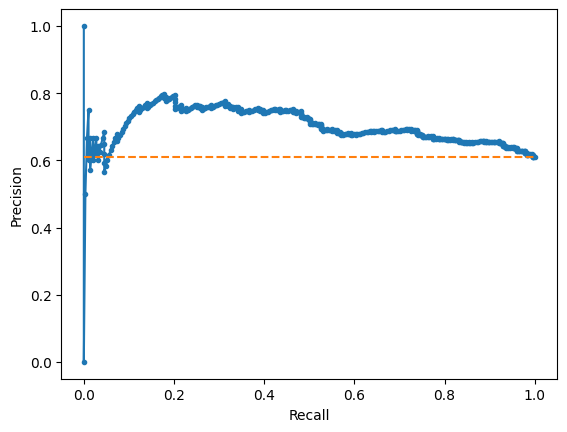

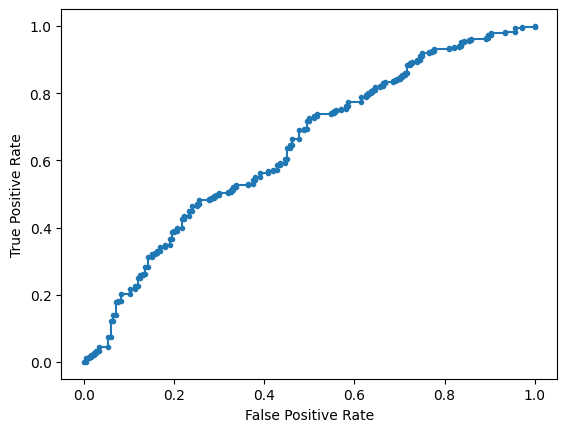

Accuracy: 60.93% Precision: 68.86% Recall: 65.51%
F1: 67.14% MCC: 0.1909
AUPRC: 70.07% AUROC: 63.93%
 accuracy [60.93418259023354]
 precision [68.86446886446886]
 recall [65.50522648083623]
 F1 [67.14285714285714]
 MCC [0.19085724070600532]
 AUPRC [70.0689188550873]
 AUROC [63.93349492501137]
 accuracy mean 60.93% std nan
 precision mean 68.86% std nan
 recall mean 65.51% std nan
 F1 mean 67.14% std nan
 MCC mean 0.1909 std nan
 AUPRC mean 70.07% std nan
 AUROC mean 63.93% std nan
 accuracy [[60.93418259023354]]
 precision [[68.86446886446886]]
 recall [[65.50522648083623]]
 F1 [[67.14285714285714]]
 MCC [[0.19085724070600532]]
 AUPRC [[70.0689188550873]]
 AUROC [[63.93349492501137]]

2023-04-19 12:26:17.162557
Cell Line 12 GM12878
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1905
Num RCI: 1905
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1905 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 473
Num RCI: 473
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 473 sequences.

Training # 1 1
2023-04-19 12:26:23.795950
2023-04-19 12:26:23.796448
Discriminator is GMM
Means [-0.29013189403629913, -2.3434539157930314]
Variances [1.26135704 2.16066452]
Priors [0.57998355 0.42001645]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 1205:700 63.25%
Computed class weights: {0: 1.3607142857142858, 1: 0.7904564315352697}
FIT
2023-04-19 12:26:25.084883


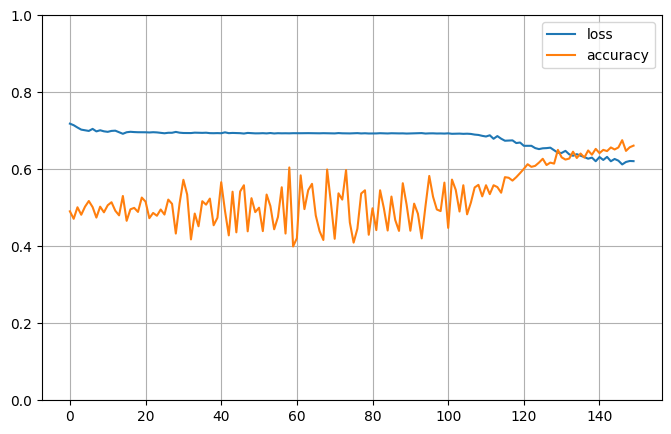


Testing # 1 1
2023-04-19 12:27:48.382200
2023-04-19 12:27:48.382253
PREDICT
2023-04-19 12:27:48.394668
Test 1:0 293:180 61.95%
Predict 1:0 308:165 65.12%
Test sizes (473, 1025) (473,)
Distrib of scores: 0.568001 mean 0.15407184 std
Range of scores: 0.13872543 to 0.88453245
Score threshold 0.5
Confusion matrix
 [[ 90  90]
 [ 75 218]]
Normalized matrix
 [[0.19027484 0.19027484]
 [0.15856237 0.46088795]]
Extreme scores correct, pos:neg 117 24
Extreme scores incorrect pos:neg 32 16


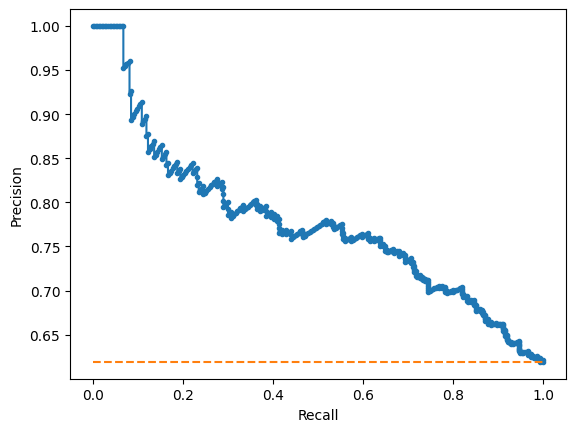

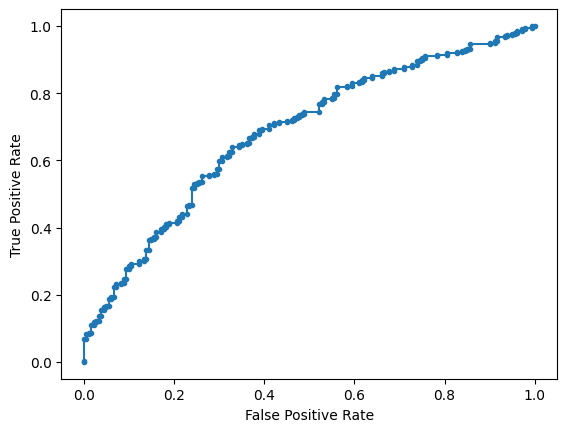

Accuracy: 65.12% Precision: 70.78% Recall: 74.40%
F1: 72.55% MCC: 0.2486
AUPRC: 77.64% AUROC: 68.34%
 accuracy [65.11627906976744]
 precision [70.77922077922078]
 recall [74.40273037542661]
 F1 [72.54575707154741]
 MCC [0.24859429273281228]
 AUPRC [77.64022538564758]
 AUROC [68.33902161547212]
 accuracy mean 65.12% std nan
 precision mean 70.78% std nan
 recall mean 74.40% std nan
 F1 mean 72.55% std nan
 MCC mean 0.2486 std nan
 AUPRC mean 77.64% std nan
 AUROC mean 68.34% std nan
 accuracy [[65.11627906976744]]
 precision [[70.77922077922078]]
 recall [[74.40273037542661]]
 F1 [[72.54575707154741]]
 MCC [[0.24859429273281228]]
 AUPRC [[77.64022538564758]]
 AUROC [[68.33902161547212]]

2023-04-19 12:27:49.011945
Cell Line 13 K562
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1040
Num RCI: 1040
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.c

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1040 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 293
Num RCI: 293
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 293 sequences.

Training # 1 1
2023-04-19 12:27:51.504729
2023-04-19 12:27:51.504807
Discriminator is GMM
Means [-0.15509047641157286, -2.542607097137772]
Variances [1.3992858  1.69215773]
Priors [0.64873974 0.35126026]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 708:332 68.08%
Computed class weights: {0: 1.5662650602409638, 1: 0.7344632768361582}
FIT
2023-04-19 12:27:52.301107


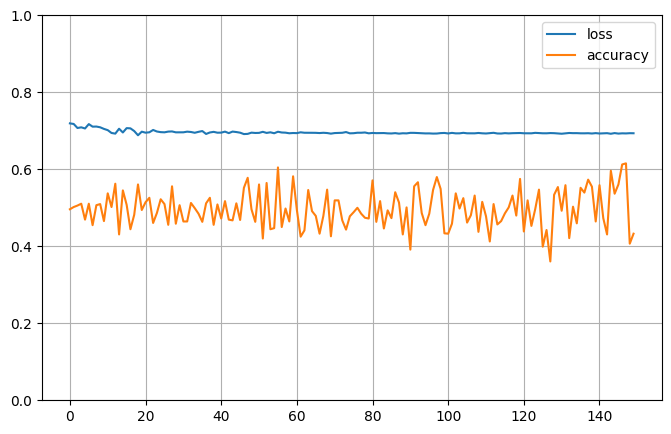


Testing # 1 1
2023-04-19 12:28:20.799996
2023-04-19 12:28:20.800058
PREDICT
2023-04-19 12:28:20.803572
Test 1:0 202:91 68.94%
Predict 1:0 293:0 100.00%
Test sizes (293, 1025) (293,)
Distrib of scores: 0.50136536 mean 7.2338764e-05 std
Range of scores: 0.50116277 to 0.5015788
Score threshold 0.5
Confusion matrix
 [[  0  91]
 [  0 202]]
Normalized matrix
 [[0.        0.3105802]
 [0.        0.6894198]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


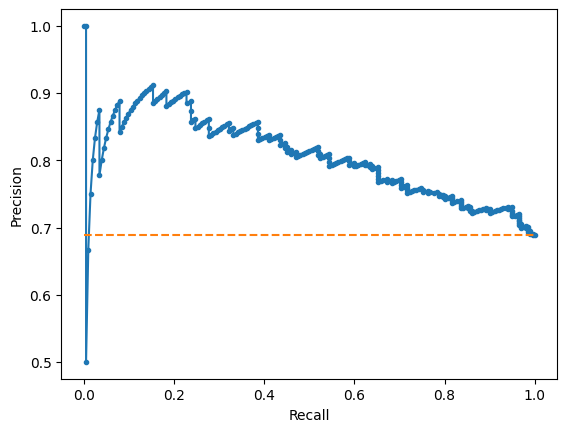

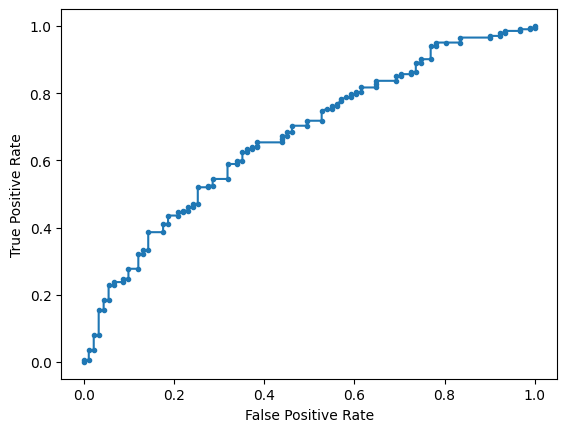

Accuracy: 68.94% Precision: 68.94% Recall: 100.00%
F1: 81.62% MCC: 0.0000
AUPRC: 80.46% AUROC: 67.14%
 accuracy [68.94197952218431]
 precision [68.94197952218431]
 recall [100.0]
 F1 [81.61616161616162]
 MCC [0.0]
 AUPRC [80.46171201217736]
 AUROC [67.14176912196714]
 accuracy mean 68.94% std nan
 precision mean 68.94% std nan
 recall mean 100.00% std nan
 F1 mean 81.62% std nan
 MCC mean 0.0000 std nan
 AUPRC mean 80.46% std nan
 AUROC mean 67.14% std nan
 accuracy [[68.94197952218431]]
 precision [[68.94197952218431]]
 recall [[100.0]]
 F1 [[81.61616161616162]]
 MCC [[0.0]]
 AUPRC [[80.46171201217736]]
 AUROC [[67.14176912196714]]

2023-04-19 12:28:21.452330
Cell Line 14 IMR.90
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 441
Num RCI: 441
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 441 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 108
Num RCI: 108
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 108 sequences.

Training # 1 1
2023-04-19 12:28:22.829499
2023-04-19 12:28:22.829929
Discriminator is GMM
Means [-2.637371770764905, 0.5571993348107099]
Variances [3.26957451 1.43718009]
Priors [0.39929755 0.60070245]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 282:159 63.95%
Computed class weights: {0: 1.3867924528301887, 1: 0.7819148936170213}
FIT
2023-04-19 12:28:25.992504


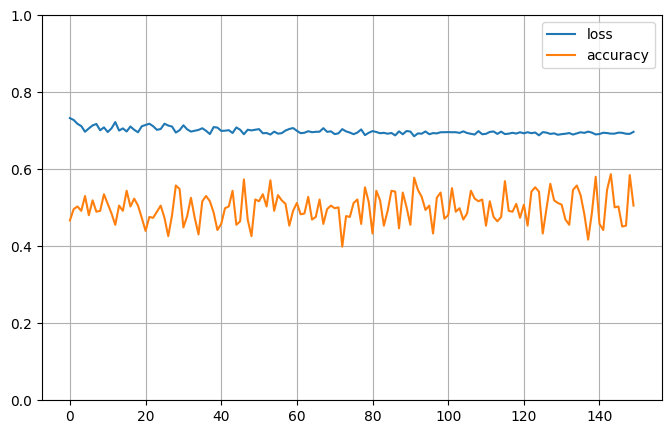


Testing # 1 1
2023-04-19 12:28:48.588346
2023-04-19 12:28:48.588396
PREDICT
2023-04-19 12:28:48.590001
Test 1:0 68:40 62.96%
Predict 1:0 7:101  6.48%
Test sizes (108, 1025) (108,)
Distrib of scores: 0.49688965 mean 0.0019288572 std
Range of scores: 0.4925924 to 0.503802
Score threshold 0.5
Confusion matrix
 [[40  0]
 [61  7]]
Normalized matrix
 [[0.37037037 0.        ]
 [0.56481481 0.06481481]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


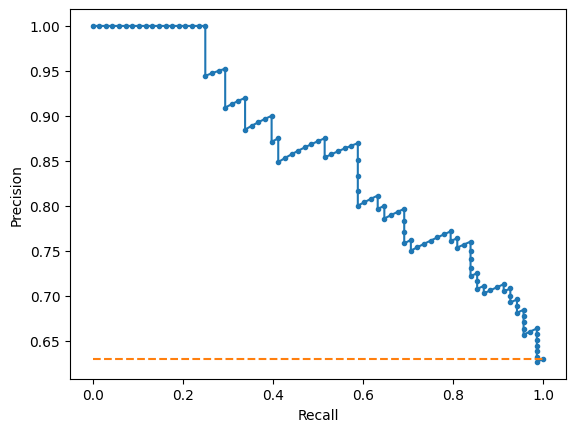

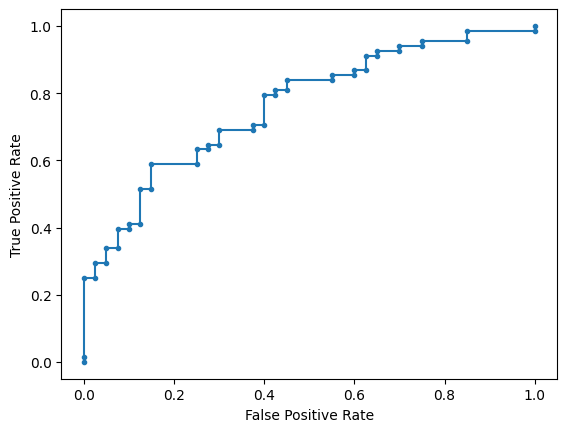

Accuracy: 43.52% Precision: 100.00% Recall: 10.29%
F1: 18.67% MCC: 0.2019
AUPRC: 85.53% AUROC: 76.32%
 accuracy [43.51851851851852]
 precision [100.0]
 recall [10.294117647058822]
 F1 [18.666666666666664]
 MCC [0.2019128097982617]
 AUPRC [85.52614503465621]
 AUROC [76.32352941176471]
 accuracy mean 43.52% std nan
 precision mean 100.00% std nan
 recall mean 10.29% std nan
 F1 mean 18.67% std nan
 MCC mean 0.2019 std nan
 AUPRC mean 85.53% std nan
 AUROC mean 76.32% std nan
 accuracy [[43.51851851851852]]
 precision [[100.0]]
 recall [[10.294117647058822]]
 F1 [[18.666666666666664]]
 MCC [[0.2019128097982617]]
 AUPRC [[85.52614503465621]]
 AUROC [[76.32352941176471]]
2023-04-19 12:28:49.331409


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
for cell_line in range(15):
    print()
    print(datetime.now())
    print('Cell Line',cell_line,all_cell_lines[cell_line])

    accuracy=[]
    precision=[]
    recall=[]
    f1=[]
    mcc=[]
    auprc=[]
    auroc=[]

    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TRAIN
    print("Load RCI from",filepath)
    gene_to_rci = loader.load_gene_rci_values(filepath,cell_line)
    print('Num RCI:', len(gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TRAIN
    print('Load sequence from',filepath)
    allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
    print('Loaded',len(allseq),'sequences.')
    test_gene_to_rci = None
    test_allids = None
    test_allseq = None
    if SEQ_FILE_TEST is not None:
        # Train on the entire train set (no cross-validation).
        # Evaluate with the test files.
        test_loader = DataLoader()
        filepath = DATA_DIR+RCI_FILE_TEST
        print("Load RCI from",filepath)
        test_gene_to_rci = test_loader.load_gene_rci_values(filepath,cell_line)
        print('Num RCI:', len(test_gene_to_rci.keys()))
        filepath = DATA_DIR+SEQ_FILE_TEST
        print('Load sequence from',filepath)
        test_allids,test_allseq = test_loader.load_spectra(filepath)
        print('Loaded',len(test_allseq),'sequences.')

    for repeat in range(REPEATS):
        for fold in range(FOLDS):
            show_r = repeat+1  # display one-based counting
            show_f = fold+1    # display one-based counting

            print()
            print("Training #",show_r,show_f)
            print(datetime.now())
            cvdo = CrossValidator(EPOCHS)
            cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
            if SEQ_FILE_TEST is None:
                # Train on 80% and evaluate on 20%.
                separator = Separator()
                separator.load(DATA_DIR,show_r,show_f)
                separator.process(allids,allseq,gene_to_rci)
                train_allids,test_allids = separator.get_ids()
                train_allseq,test_allseq = separator.get_seq()
                train_gene_to_rci,test_gene_to_rci = separator.get_rci()
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    test_allids,test_allseq,test_gene_to_rci)
                if SAVE_MODEL_FILENAME is not None:
                    filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                    cvdo.save_model(filename)
            else:
                # Train on the entire train set (no cross-validation).
                # Evaluate with the test files.
                train_allids = allids
                train_allseq = allseq
                train_gene_to_rci = gene_to_rci
                BREAK = True
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

            print()
            print("Testing #",show_r,show_f)
            print(datetime.now())
            cvdo.reset_statistics()
            cvdo.test_without_training(
                test_allids,test_allseq,test_gene_to_rci)
            cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
                cvdo.get_statistics()

            print(" accuracy" ,  cv_accuracy)
            print(" precision" , cv_precision)
            print(" recall" ,    cv_recall)
            print(" F1" ,        cv_f1)
            print(" MCC" ,       cv_mcc)
            print(" AUPRC" ,     cv_auprc)
            print(" AUROC" ,     cv_auroc)

            accuracy.append(cv_accuracy)
            precision.append(cv_precision)
            recall.append(cv_recall)
            f1.append(cv_f1)
            mcc.append(cv_mcc)
            auprc.append(cv_auprc)
            auroc.append(cv_auroc)
            if BREAK: break
        if BREAK: break

    print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
    print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
    print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
    print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
    print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
    print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
    print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

    print(" accuracy"  , accuracy)
    print(" precision" , precision)
    print(" recall"    , recall)
    print(" F1"        , f1)
    print(" MCC"       , mcc)
    print(" AUPRC"     , auprc)
    print(" AUROC"     , auroc)
print(datetime.now())